# 2) <u> ML Capstone: FOREX Time Series Forecasting </u>

<font color='blue'> Scripts by Kevin Jeswani
<br>
WeCloudData Bootcamp 2022 (Part-time Cohort)<br> </font>

First financial stock ticker, stock options, and other indicator data is gathered from the EODHD API

The set of scripts in the folder 'AirPollution_Scripts' are segmented for the purpose of clarity & convenience <br>
The following is the suggested order for running the scripts:
- 'XX.ipynb' **This Script** - XX
- 'XX.ipynb' - XX
- 'XX.ipynb' - XX
- 'XX.ipynb' - XX

Data is gathered from:
- The EOD Historical Data API: https://eodhistoricaldata.com/
- Unofficial Python SDK for EODHD: https://github.com/LautaroParada/eod-data
<br>

## Standard Imports and General Settings

In [155]:
import timeit #To time processes
from tqdm.notebook import tqdm #for status bar
import warnings
warnings.filterwarnings('ignore') #ignore warnings

# Data Processing
import pandas as pd
import math
pd.options.mode.chained_assignment = None  # default='warn', override copywithsetting
import numpy as np
import csv
import time
import datetime # required for creating date-time arrays or unix time codes for EODHD intra-day
from datetime import timedelta
from textwrap import wrap #string processing

# Data Storage
import csv
from pandas import HDFStore


# Plotting
import matplotlib as mpl #Matplot lib
import matplotlib.pyplot as plt #pyplot
import seaborn as sns #seaborn
sns.set() 

# SkLearn - ML
import sklearn
from sklearn.preprocessing import MinMaxScaler 
# Evaluation metrics
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, r2_score

# Deep Learning - TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential #Sequential model - constructed of many layers
from tensorflow.keras.optimizers import Adam #standard optimizer used in LSTM forecasting examples

# Technical Analysis Library - financial indicator calcs
import ta

ModuleNotFoundError: No module named 'talib'

In [18]:
root = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Scripts'
root_raw = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Scripts\Scraped_Data'
root_results = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Scripts\Results'

In [19]:
# General pandas display otpions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 10)

In [4]:
# Store ipynb session results 
#dill.dump_session('Forex_TimeSeries_6.db')
#dill.load_session('Forex_TimeSeries_1.db')

Generate currency lists

In [20]:
from itertools import combinations
currencies = ['EUR','USD','CAD','JPY','CHF','INR']
curr_pairs = ["".join(map(str, comb)) for comb in combinations(currencies, 2)] #Create currency pairs 
curr_pairs_alt = [wrap(c,3)[1]+wrap(c,3)[0] for c in curr_pairs] #alternative currency pair order as EOD has missing data
tickers = [c+'.FOREX' for c in curr_pairs]
tickers_alt = [c+'.FOREX' for c in curr_pairs_alt] #alternative order tickers

## Load Data

Merged daily ticker data with updated reduced technical indicators, etc.

In [23]:
fid=r'\DailyForex_Indicators_Reduced.pkl'
df_daily_red = pd.read_pickle(root_results+fid) 

Intra-day ticker day sampled at 15min increments

In [24]:
# Load Intra-day Tick Data
increment = '15m' 
IDTicks = {}
for t,ticker in enumerate(tickers):
    #load from h5 for each ticker
    df_ID = pd.read_hdf(root_raw+r'\FOREX_15min.h5',mode='r+',key='/'+ticker.replace(".","_")+'_'+increment) 
    # Store to dictionary
    IDTicks[ticker] = df_ID

# Machine Learning - Deep Learning

Deep Learning will be carried out only on **EUR-USD** but intra-daily values will be used with the LSTM.

In [13]:
# Exogenous features available for model - only select technical indicators
exog_feats = ['rsi','adx','dmi','macd_norm','bbands_norm','sar_norm','ma_position','fastkline','fastdline','k_values','d_values','Sentiment_norm']

In [202]:
ticker = currs[0]
df_in = IDTicks[ticker]
startdate = df_in[df_in['Ticker']==ticker].index[0] #first day

### Train-Train Split

In [68]:
# Define the split dates
split1 = datetime.datetime.strptime('2022-08-01',"%Y-%m-%d")
split2 = datetime.datetime.strptime('2022-01-01',"%Y-%m-%d")
#start_date = datetime.datetime.strptime('2010-10-02',"%Y-%m-%d") #move up first day to account for differenced first day of series

In [260]:
startdate = df_in.index[0] #first day
full = df_in[(df_in.index >=startdate)] #full dataset
train = df_in[(df_in.index >=startdate)&(df_in.index <split2)] #train dataset
test = df_in[(df_in.index<split1)&(df_in.index>=split2)]
holdout = df_in[(df_in.index>=split1)]

## LSTM (Long-term Short-term Memory, RNN)

Background:
- Optimizer: Nesterov Adam  = combination of Nesterov Momentum & Adam CMM - see for explanation: https://towardsdatascience.com/neural-network-optimization-algorithms-1a44c282f61d <br>
    - reasoning - spaces parameter updates of the optimizer - helps the network get out of local minima <br>
    - momentum method - allows the network to look ahead so it does not fall into local minimas
    - squares gradients to change learning rate and uses moving average of the gradient vs. gradient itself <br>
- Will predict steps ahead based on lags behind (similar to other models)
Sources: https://medium.com/analytics-vidhya/using-convlstms-to-predict-forex-prices-e75685e93129 <br>

### Baseline Model

In [27]:
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

In [73]:
# Add lags - use forward lags instead of example
def add_lags(df_in,lag_matrix):
    '''
    Splits input df with only one target features and adds n columns for backward lags
    df_in = input dataframe with close prices
    first_str = string date of window start
    last_str = string date of window last day
    lag_matrix = list of lags to add as additional column
    n = number of lagged columns
    '''
    n = len(lag_matrix) #get number of lags
    df_out = df_in
    # Add columns for the spefied backward lags
    for nn in range(n): #add columns of specified backward lag
        df_out['close_L'+str(lag_matrix[nn])] = df_in['close'].shift(lag_matrix[nn])    
    return df_out

In [255]:
train_lagged = add_lags(train[['close','date']],lag_matrix=[7,14,30]).dropna()
test_lagged  = add_lags(test[['close','date']],lag_matrix=[7,14,30]).dropna()
holdout_lagged  = add_lags(holdout[['close','date']],lag_matrix=[7,14,30]).dropna()

In [213]:
def df_to_np(df_in,exog):
    '''
    Converts close price and date df, and additional lagged price to np arrays
    in the proper shape required for NN input
    df_in = input df
    exog = string list of exogenous variables
    '''
    # Convert dates to numpy array
    dates = df_in['date'].to_numpy()
    # Extract lagged feature cols and convert to np
    features = df_in[exog].to_numpy()
    # Reshape features for NN input
    X = features.reshape((len(dates), features.shape[1], 1)) 
    # Target var = y
    Y = df_in['close'].to_numpy()
    return dates, X.astype(np.float32), Y.astype(np.float32)

#### Test Train Split & Convert to NpP arrays for NN

In [258]:
# Convert the windowed df to np arrays for the NN input
dates_train, X_train, y_train = df_to_np(train_lagged,exog=['close_L7','close_L14','close_L30'])
dates_test, X_test, y_test = df_to_np(test_lagged,exog=['close_L7','close_L14','close_L30'])
dates_hov, X_hov, y_hov = df_to_np(holdout_lagged,exog=['close_L7','close_L14','close_L30'])
# Check the shape
dates_train.shape, X_train.shape, y_train.shape

((266277,), (266277, 3, 1), (266277,))

Text(0, 0.5, 'Exchange Rate EUR:USD')

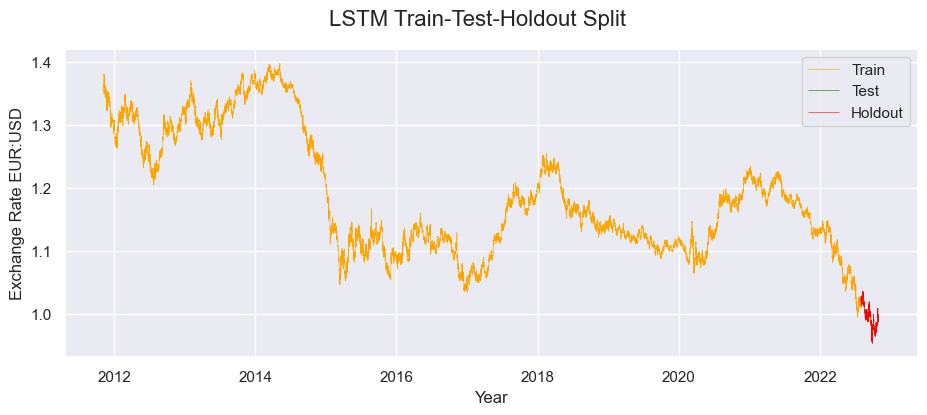

In [262]:
# Test-Train-Holdout-Split
fig,ax = plt.subplots(figsize=(11, 4))
plt.plot(dates_train, y_train,color='orange',linewidth=0.4)
plt.plot(dates_hov, y_hov,color='green',linewidth=0.4)
plt.plot(dates_test, y_test,'red',linewidth=0.4)
#plt.xlim([datetime.datetime.strptime('2022-08-01',"%Y-%m-%d"),datetime.datetime.strptime('2022-08-30',"%Y-%m-%d")]) #x-range
plt.legend(['Train', 'Test', 'Holdout'])
fig.suptitle('LSTM Train-Test-Holdout Split',fontsize=16) #main title slight elevated above subplots
ax.set_xlabel('Year',fontsize=12)
ax.set_ylabel('Exchange Rate EUR:USD',fontsize=12)

#### Setup LSTM & Train

In [264]:
# Define the model
model = Sequential([layers.Input((3, 1)), #3 = 3 past day features, and only 1 univariate forecasted feature = target
                    layers.LSTM(64), #LSTM layer - vague, but not too large of a number; avoid overfitting
                    layers.Dense(32, activation='relu'), #stacked dense layers - approximating hovues; not too large; avoid overfitting
                    layers.Dense(32, activation='relu'), #rectified linear unit activation function;
                    #....allows models to learn fast and avoids issues due to vanishing gradient problem
                    layers.Dense(1)]) #default linear activation function to end
# Compile the model
model.compile(loss='mse',  #minimize mean squared error for loss function - differentiable
              optimizer=Adam(learning_rate=0.001), #Adam optimizer - learning_rate starting value
              metrics=['mean_absolute_error']) #additional validation metric metric
# Fit the model on training data while scoring loss to testing set
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100) #100 runs/epoch through data set

Epoch 1/100
8322/8322 [==============================] - 35s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0062 - val_loss: 6.0339e-06 - val_mean_absolute_error: 0.0018
Epoch 2/100
8322/8322 [==============================] - 32s 4ms/step - loss: 1.1048e-05 - mean_absolute_error: 0.0026 - val_loss: 2.4073e-05 - val_mean_absolute_error: 0.0044
Epoch 3/100
8322/8322 [==============================] - 32s 4ms/step - loss: 1.0236e-05 - mean_absolute_error: 0.0025 - val_loss: 6.2130e-06 - val_mean_absolute_error: 0.0018
Epoch 4/100
8322/8322 [==============================] - 31s 4ms/step - loss: 9.3874e-06 - mean_absolute_error: 0.0024 - val_loss: 5.9053e-06 - val_mean_absolute_error: 0.0018
Epoch 5/100
8322/8322 [==============================] - 34s 4ms/step - loss: 8.8922e-06 - mean_absolute_error: 0.0023 - val_loss: 2.3874e-05 - val_mean_absolute_error: 0.0044
Epoch 6/100
8322/8322 [==============================] - 35s 4ms/step - loss: 8.3476e-06 - mean_absolute_error: 0.0022 - val

8322/8322 [==============================] - 30s 4ms/step - loss: 4.0709e-06 - mean_absolute_error: 0.0015 - val_loss: 6.1122e-06 - val_mean_absolute_error: 0.0019
Epoch 48/100
8322/8322 [==============================] - 30s 4ms/step - loss: 4.0307e-06 - mean_absolute_error: 0.0015 - val_loss: 4.0561e-06 - val_mean_absolute_error: 0.0014
Epoch 49/100
8322/8322 [==============================] - 30s 4ms/step - loss: 4.0614e-06 - mean_absolute_error: 0.0015 - val_loss: 4.8568e-06 - val_mean_absolute_error: 0.0016
Epoch 50/100
8322/8322 [==============================] - 30s 4ms/step - loss: 4.0649e-06 - mean_absolute_error: 0.0015 - val_loss: 5.4779e-06 - val_mean_absolute_error: 0.0018
Epoch 51/100
8322/8322 [==============================] - 30s 4ms/step - loss: 4.0503e-06 - mean_absolute_error: 0.0015 - val_loss: 8.6490e-06 - val_mean_absolute_error: 0.0024
Epoch 52/100
8322/8322 [==============================] - 30s 4ms/step - loss: 4.0232e-06 - mean_absolute_error: 0.0015 - val_lo

8322/8322 [==============================] - 28s 3ms/step - loss: 3.5800e-06 - mean_absolute_error: 0.0014 - val_loss: 2.5475e-04 - val_mean_absolute_error: 0.0113
Epoch 94/100
8322/8322 [==============================] - 28s 3ms/step - loss: 3.6163e-06 - mean_absolute_error: 0.0014 - val_loss: 2.7823e-04 - val_mean_absolute_error: 0.0117
Epoch 95/100
8322/8322 [==============================] - 28s 3ms/step - loss: 3.6021e-06 - mean_absolute_error: 0.0014 - val_loss: 2.7174e-04 - val_mean_absolute_error: 0.0114
Epoch 96/100
8322/8322 [==============================] - 29s 4ms/step - loss: 3.5766e-06 - mean_absolute_error: 0.0014 - val_loss: 2.7548e-04 - val_mean_absolute_error: 0.0115
Epoch 97/100
8322/8322 [==============================] - 28s 3ms/step - loss: 3.6094e-06 - mean_absolute_error: 0.0014 - val_loss: 2.7223e-04 - val_mean_absolute_error: 0.0116
Epoch 98/100
8322/8322 [==============================] - 29s 3ms/step - loss: 3.6291e-06 - mean_absolute_error: 0.0014 - val_lo

#### Examine the predictions

In [286]:
# Predict through the training data
train_predictions = model.predict(X_train).flatten()
# Predict the testing data
test_predictions = model.predict(X_test).flatten()
# Hold-out hov data fails
hov_predictions = model.predict(X_hov).flatten()

199/199 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Exchange Rate EUR:USD')

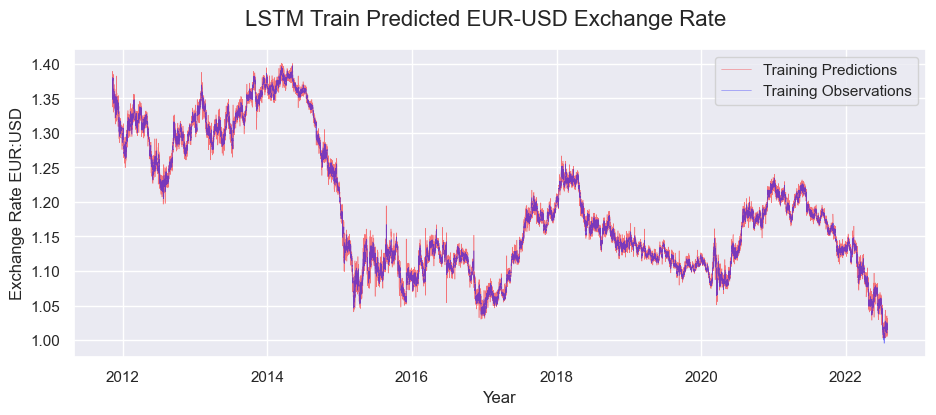

In [287]:
# Plot Training
fig,ax = plt.subplots(figsize=(11, 4))
plt.plot(dates_train, train_predictions,linewidth=0.4,color='red',alpha=0.5)
plt.plot(dates_train, y_train,linewidth=0.4,color='blue',alpha=0.5)
plt.legend(['Training Predictions', 'Training Observations'])
fig.suptitle('LSTM Train Predicted EUR-USD Exchange Rate',fontsize=16) #main title slight elevated above subplots
ax.set_xlabel('Year',fontsize=12)
ax.set_ylabel('Exchange Rate EUR:USD',fontsize=12)

Text(0, 0.5, 'Exchange Rate EUR:USD')

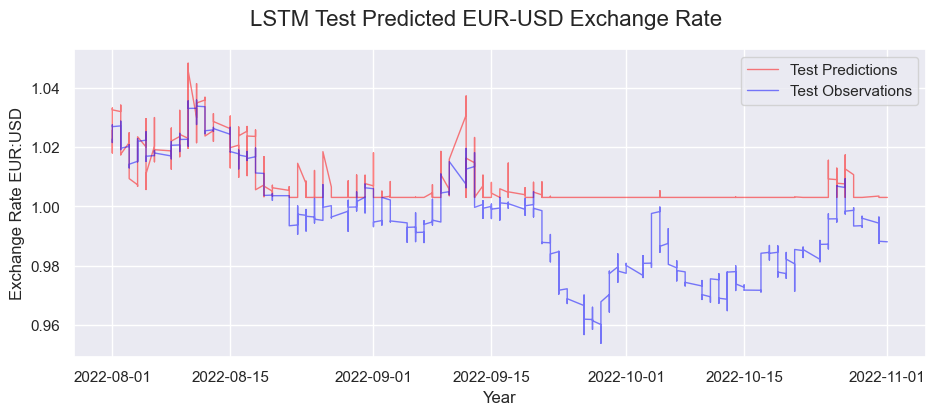

In [288]:
# Plot Testing
fig,ax = plt.subplots(figsize=(11, 4))
plt.plot(dates_test, test_predictions,linewidth=1,color='red',alpha=0.5)
plt.plot(dates_test, y_test,linewidth=1,color='blue',alpha=0.5)
plt.legend(['Test Predictions', 'Test Observations'])
fig.suptitle('LSTM Test Predicted EUR-USD Exchange Rate',fontsize=16) #main title slight elevated above subplots
ax.set_xlabel('Year',fontsize=12)
ax.set_ylabel('Exchange Rate EUR:USD',fontsize=12)

In [290]:
# Forecast Evaluation
print('MSE: ',round(MSE(y_test,test_predictions),4),
      'MAE: ',round(MAE(y_test,test_predictions),4),
      'R2: ',round(r2_score(y_test,test_predictions),4),
     )

MSE:  0.0003 MAE:  0.0123 R2:  0.0775


From around July 2022 in the testing data, there seems to be a plateau. This strange behaviour continues on into the hold-out validation.

In [271]:
# Save Model
!mkdir -p saved_model
model.save('LSTM_Forex/Model1')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: LSTM_Forex/Model1\assets


INFO:tensorflow:Assets written to: LSTM_Forex/Model1\assets


This model is not appropriate for long term predictions, however it could be used to predict prices 1 week to 1 month in the future. It could be routinely retrained everyday with new information.

### Updated Model with Exponential Moving Average (EMA)

#### Prepare the Data - Add EMA

In [272]:
df_in_EMA = df_in[['date','close']] #only extract the basic close and date

In [273]:
# Use TA-lib to add two long period exponential moving averages 100 & 200 day
for n in [50,100,200]:
    df_in_EMA.loc[:,'EMA_'+str(n)] = ema_indicator(df_in_EMA['close'],window=n,fillna=False) #call TA package for EMA

In [274]:
df_in_EMA = df_in_EMA.dropna()

In [275]:
df_in_EMA

,date,close,EMA_50,EMA_100,EMA_200
timestamp,,,,,
2010-10-05 02:30:00,2010-10-05,1.36761,1.369262,1.370403,1.370126
2010-10-05 02:45:00,2010-10-05,1.36757,1.369195,1.370347,1.370101
2010-10-05 03:00:00,2010-10-05,1.36751,1.369129,1.370291,1.370075
2010-10-05 03:15:00,2010-10-05,1.36641,1.369023,1.370214,1.370038
2010-10-05 03:30:00,2010-10-05,1.36542,1.368881,1.370119,1.369992
...,...,...,...,...,...
2022-10-31 23:00:00,2022-10-31,0.98800,0.992590,0.993883,0.995388
2022-10-31 23:15:00,2022-10-31,0.98858,0.992433,0.993778,0.995320
2022-10-31 23:30:00,2022-10-31,0.98752,0.992240,0.993654,0.995243


In [276]:
#Test-Train Split - no holdout
startdate = df_in_EMA.index[0] #first day
full_EMA = df_in_EMA
train_EMA = df_in_EMA[(df_in_EMA.index >=startdate)&(df_in_EMA.index <split1)] #train dataset
test_EMA = df_in_EMA[(df_in_EMA.index>=split1)]

In [277]:
# Convert the windowed df to np arrays for the NN input
exogs = ['EMA_'+str(n) for n in [50,100,200]]
dates_train_EMA, X_train_EMA, y_train_EMA = df_to_np(train_EMA,exog=exogs)
dates_test_EMA, X_test_EMA, y_test_EMA = df_to_np(test_EMA,exog=exogs)
# Check the shape
dates_train_EMA.shape, X_train_EMA.shape, y_train_EMA.shape

((293555,), (293555, 3, 1), (293555,))

#### Setup LSTM & Train

In [279]:
# Define the model
model2 = Sequential([layers.Input((3, 1)), #3 = 3 past day features, and only 1 univariate forecasted feature = target
                    layers.LSTM(64), #LSTM layer - vague, but not too large of a number; avoid overfitting
                    layers.Dense(32, activation='relu'), #stacked dense layers - approximating hovues; not too large; avoid overfitting
                    layers.Dense(32, activation='relu'), #rectified linear unit activation function;
                    #....allows models to learn fast and avoids issues due to vanishing gradient problem
                    layers.Dense(1)]) #default linear activation function to end
# Compile the model
model2.compile(loss='mse',  #minimize mean squared error for loss function - differentiable
              optimizer=Adam(learning_rate=0.001), #Adam optimizer - learning_rate starting value
              metrics=['mean_absolute_error']) #additional validation metric metric
# Fit the model on training data while scoring loss to testing set
model2.fit(X_train_EMA, y_train_EMA, validation_data=(X_test_EMA, y_test_EMA), epochs=200) #200 runs/epoch through data set

Epoch 1/200
9174/9174 [==============================] - 35s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0065 - val_loss: 3.0555e-05 - val_mean_absolute_error: 0.0047
Epoch 2/200
9174/9174 [==============================] - 33s 4ms/step - loss: 1.9073e-05 - mean_absolute_error: 0.0034 - val_loss: 1.1535e-05 - val_mean_absolute_error: 0.0026
Epoch 3/200
9174/9174 [==============================] - 33s 4ms/step - loss: 1.8040e-05 - mean_absolute_error: 0.0033 - val_loss: 1.1277e-05 - val_mean_absolute_error: 0.0026
Epoch 4/200
9174/9174 [==============================] - 33s 4ms/step - loss: 1.6631e-05 - mean_absolute_error: 0.0031 - val_loss: 1.0775e-05 - val_mean_absolute_error: 0.0025
Epoch 5/200
9174/9174 [==============================] - 33s 4ms/step - loss: 1.5994e-05 - mean_absolute_error: 0.0031 - val_loss: 1.1101e-05 - val_mean_absolute_error: 0.0026
Epoch 6/200
9174/9174 [==============================] - 33s 4ms/step - loss: 1.4468e-05 - mean_absolute_error: 0.0029 - val

9174/9174 [==============================] - 31s 3ms/step - loss: 4.6413e-06 - mean_absolute_error: 0.0016 - val_loss: 2.7141e-04 - val_mean_absolute_error: 0.0115
Epoch 48/200
9174/9174 [==============================] - 31s 3ms/step - loss: 4.6776e-06 - mean_absolute_error: 0.0016 - val_loss: 2.7658e-04 - val_mean_absolute_error: 0.0117
Epoch 49/200
9174/9174 [==============================] - 31s 3ms/step - loss: 4.6310e-06 - mean_absolute_error: 0.0016 - val_loss: 2.7785e-04 - val_mean_absolute_error: 0.0115
Epoch 50/200
9174/9174 [==============================] - 31s 3ms/step - loss: 4.5862e-06 - mean_absolute_error: 0.0016 - val_loss: 3.1025e-04 - val_mean_absolute_error: 0.0130
Epoch 51/200
9174/9174 [==============================] - 31s 3ms/step - loss: 4.5479e-06 - mean_absolute_error: 0.0016 - val_loss: 2.9509e-04 - val_mean_absolute_error: 0.0121
Epoch 52/200
9174/9174 [==============================] - 31s 3ms/step - loss: 4.5525e-06 - mean_absolute_error: 0.0016 - val_lo

9174/9174 [==============================] - 32s 4ms/step - loss: 4.2162e-06 - mean_absolute_error: 0.0015 - val_loss: 2.6950e-04 - val_mean_absolute_error: 0.0113
Epoch 94/200
9174/9174 [==============================] - 32s 3ms/step - loss: 4.2688e-06 - mean_absolute_error: 0.0015 - val_loss: 2.6668e-04 - val_mean_absolute_error: 0.0112
Epoch 95/200
9174/9174 [==============================] - 32s 4ms/step - loss: 4.2789e-06 - mean_absolute_error: 0.0015 - val_loss: 2.7306e-04 - val_mean_absolute_error: 0.0116
Epoch 96/200
9174/9174 [==============================] - 32s 4ms/step - loss: 4.2929e-06 - mean_absolute_error: 0.0015 - val_loss: 2.8318e-04 - val_mean_absolute_error: 0.0118
Epoch 97/200
9174/9174 [==============================] - 33s 4ms/step - loss: 4.2572e-06 - mean_absolute_error: 0.0015 - val_loss: 2.7950e-04 - val_mean_absolute_error: 0.0117
Epoch 98/200
9174/9174 [==============================] - 32s 4ms/step - loss: 4.2248e-06 - mean_absolute_error: 0.0015 - val_lo

9174/9174 [==============================] - 33s 4ms/step - loss: 4.0279e-06 - mean_absolute_error: 0.0015 - val_loss: 2.7223e-04 - val_mean_absolute_error: 0.0116
Epoch 140/200
9174/9174 [==============================] - 34s 4ms/step - loss: 3.9875e-06 - mean_absolute_error: 0.0015 - val_loss: 2.7210e-04 - val_mean_absolute_error: 0.0114
Epoch 141/200
9174/9174 [==============================] - 35s 4ms/step - loss: 3.9917e-06 - mean_absolute_error: 0.0015 - val_loss: 2.8433e-04 - val_mean_absolute_error: 0.0118
Epoch 142/200
9174/9174 [==============================] - 37s 4ms/step - loss: 4.0285e-06 - mean_absolute_error: 0.0015 - val_loss: 2.7894e-04 - val_mean_absolute_error: 0.0116
Epoch 143/200
9174/9174 [==============================] - 35s 4ms/step - loss: 3.9928e-06 - mean_absolute_error: 0.0015 - val_loss: 2.7415e-04 - val_mean_absolute_error: 0.0116
Epoch 144/200
9174/9174 [==============================] - 37s 4ms/step - loss: 3.9828e-06 - mean_absolute_error: 0.0015 - v

9174/9174 [==============================] - 36s 4ms/step - loss: 3.8307e-06 - mean_absolute_error: 0.0014 - val_loss: 2.8374e-04 - val_mean_absolute_error: 0.0117
Epoch 186/200
9174/9174 [==============================] - 34s 4ms/step - loss: 3.8469e-06 - mean_absolute_error: 0.0014 - val_loss: 2.6564e-04 - val_mean_absolute_error: 0.0116
Epoch 187/200
9174/9174 [==============================] - 34s 4ms/step - loss: 3.7978e-06 - mean_absolute_error: 0.0014 - val_loss: 2.8940e-04 - val_mean_absolute_error: 0.0120
Epoch 188/200
9174/9174 [==============================] - 34s 4ms/step - loss: 3.8588e-06 - mean_absolute_error: 0.0014 - val_loss: 2.7616e-04 - val_mean_absolute_error: 0.0115
Epoch 189/200
9174/9174 [==============================] - 34s 4ms/step - loss: 3.8176e-06 - mean_absolute_error: 0.0014 - val_loss: 2.6243e-04 - val_mean_absolute_error: 0.0111
Epoch 190/200
9174/9174 [==============================] - 33s 4ms/step - loss: 3.7702e-06 - mean_absolute_error: 0.0014 - v

#### Evaluate the Model

In [280]:
# Predict through the training data
train_predictions_EMA = model2.predict(X_train_EMA).flatten()
# Predict the testing data
test_predictions_EMA = model2.predict(X_test_EMA).flatten()

200/200 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Exchange Rate EUR:USD')

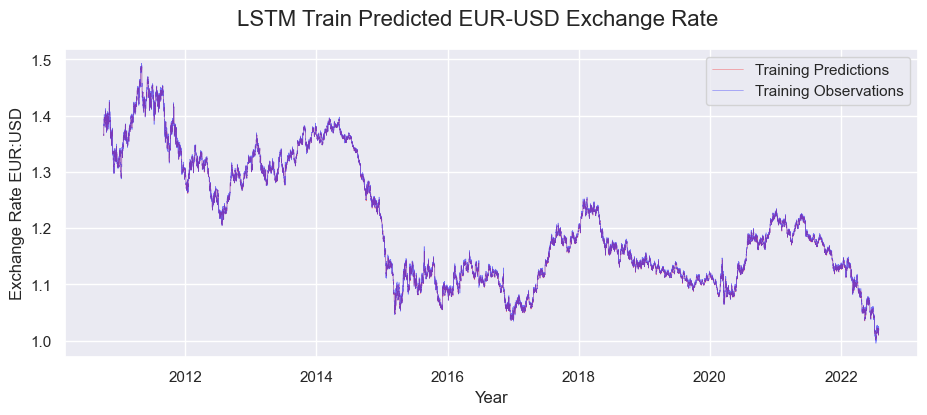

In [281]:
# Plot Training
fig,ax = plt.subplots(figsize=(11, 4))
plt.plot(dates_train_EMA, train_predictions_EMA,linewidth=0.4,color='red',alpha=0.5)
plt.plot(dates_train_EMA, y_train_EMA,linewidth=0.4,color='blue',alpha=0.5)
plt.legend(['Training Predictions', 'Training Observations'])
fig.suptitle('LSTM Train Predicted EUR-USD Exchange Rate',fontsize=16) #main title slight elevated above subplots
ax.set_xlabel('Year',fontsize=12)
ax.set_ylabel('Exchange Rate EUR:USD',fontsize=12)

Text(0, 0.5, 'Exchange Rate EUR:USD')

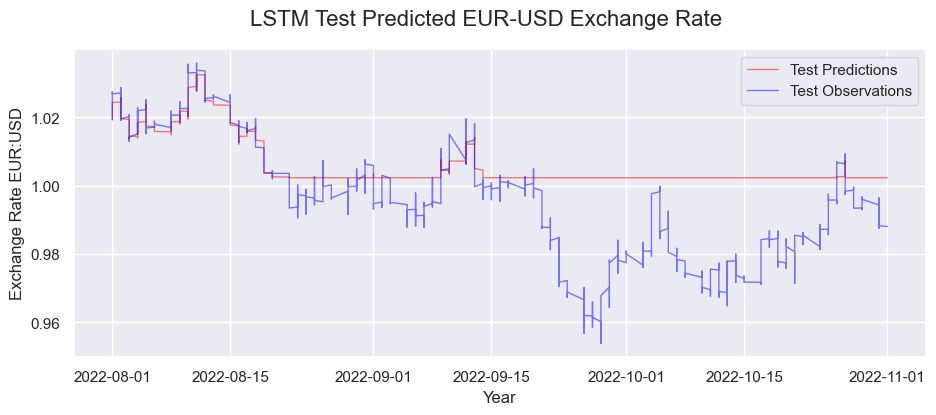

In [282]:
# Plot Testing
fig,ax = plt.subplots(figsize=(11, 4))
plt.plot(dates_test_EMA, test_predictions_EMA,linewidth=1,color='red',alpha=0.5)
plt.plot(dates_test_EMA, y_test_EMA,linewidth=1,color='blue',alpha=0.5)
plt.legend(['Test Predictions', 'Test Observations'])
fig.suptitle('LSTM Test Predicted EUR-USD Exchange Rate',fontsize=16) #main title slight elevated above subplots
ax.set_xlabel('Year',fontsize=12)
ax.set_ylabel('Exchange Rate EUR:USD',fontsize=12)

Short-term test forecast

Text(0, 0.5, 'Exchange Rate EUR:USD')

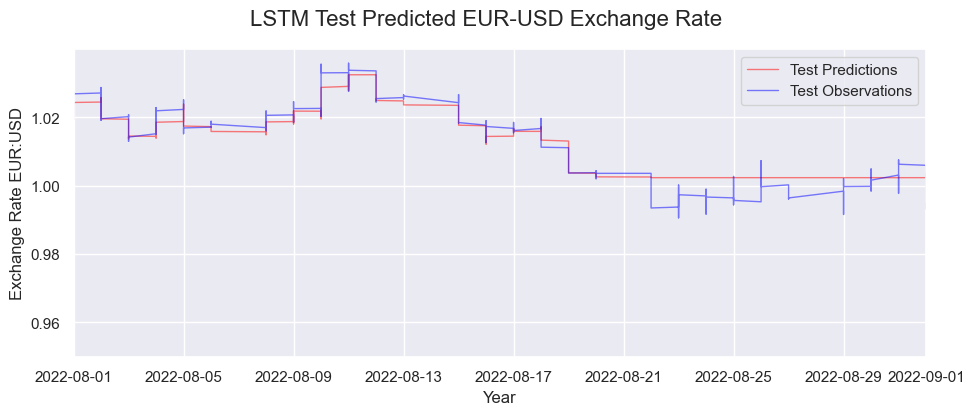

In [283]:
# Plot Testing- short term 
fig,ax = plt.subplots(figsize=(11, 4))
plt.plot(dates_test_EMA, test_predictions_EMA,linewidth=1,color='red',alpha=0.5)
plt.plot(dates_test_EMA, y_test_EMA,linewidth=1,color='blue',alpha=0.5)
plt.xlim([datetime.datetime.strptime('2022-08-01',"%Y-%m-%d"),datetime.datetime.strptime('2022-09-01',"%Y-%m-%d")]) #x-range
plt.legend(['Test Predictions', 'Test Observations'])
fig.suptitle('LSTM Test Predicted EUR-USD Exchange Rate',fontsize=16) #main title slight elevated above subplots
ax.set_xlabel('Year',fontsize=12)
ax.set_ylabel('Exchange Rate EUR:USD',fontsize=12)

Evaluation Metrics:

In [284]:
# Forecast Evaluation
print('MSE: ',round(MSE(y_test_EMA,test_predictions_EMA),4),
      'MAE: ',round(MAE(y_test_EMA,test_predictions_EMA),4),
      'R2: ',round(r2_score(y_test_EMA,test_predictions_EMA),4),
     )

MSE:  0.0003 MAE:  0.0114 R2:  0.1487


In [285]:
# Save Model
!mkdir -p saved_model
model2.save('LSTM_Forex/Model2')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: LSTM_Forex/Model2\assets


INFO:tensorflow:Assets written to: LSTM_Forex/Model2\assets


The Moving average doesn't appear to do much better for more than a few weeks. It generally doesn't catch any big swings.